In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)


In [ ]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 [==============================] - 34s 83ms/step - loss: 4.1831 - accuracy: 0.0787 - top-5-accuracy: 0.2421 - val_loss: 3.8638 - val_accuracy: 0.1322 - val_top-5-accuracy: 0.3590
Epoch 2/30
352/352 [==============================] - 28s 79ms/step - loss: 3.6079 - accuracy: 0.1871 - top-5-accuracy: 0.4584 - val_loss: 3.4541 - val_accuracy: 0.2202 - val_top-5-accuracy: 0.5094
Epoch 3/30
352/352 [==============================] - 28s 79ms/step - loss: 3.3141 - accuracy: 0.2529 - top-5-accuracy: 0.5562 - val_loss: 3.2353 - val_accuracy: 0.2658 - val_top-5-accuracy: 0.5800
Epoch 4/30
352/352 [==============================] - 28s 78ms/step - loss: 3.1252 - accuracy: 0.2981 - top-5-accuracy: 0.6127 - val_loss: 3.0371 - val_accuracy: 0.3250 - val_top-5-accuracy: 0.6368
Epoch 5/30
352/352 [==============================] - 28s 79ms/step - loss: 2.9587 - accuracy: 0.3422 - top-5-accuracy: 0.6621 - val_loss: 2.9731 - val_accuracy: 0.3362 - val_top-5-accuracy: 0.6650
Epoch 6/30

In [ ]:
from google.colab import files

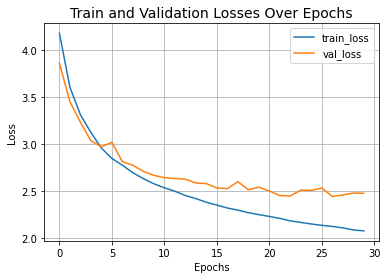

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()
plt.savefig('CCT100L.png')
files.download('CCT100L.png')

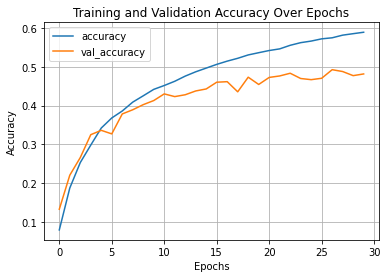

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs", fontsize=12)
plt.legend()
plt.grid()
plt.show()
plt.savefig('CCT100Acc.png')
files.download('CCT100Acc.png')

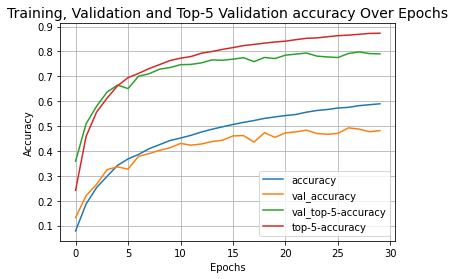

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(history.history["val_top-5-accuracy"], label="val_top-5-accuracy")
plt.plot(history.history["top-5-accuracy"], label="top-5-accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation and Top-5 Validation accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()
plt.savefig('CCT100Acc3.png')
files.download('CCT100Acc3.png')